In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import img_to_array, load_img
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.io import imshow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, concatenate
from tensorflow.keras.layers import Add
from keras.layers import Activation, Dense, Dropout, Flatten
from skimage.color import gray2rgb
from skimage.color import rgb2lab
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:

# Define paths for dataset directories
data_directory = 'dataset'
color_image_directory = os.path.join(data_directory, 'class 0')  # Directory for colored images
grayscale_image_directory = os.path.join(data_directory, 'class 1')  # Directory for grayscale images

# Specify dimensions for resizing all images (e.g., 256x256)
TARGET_HEIGHT, TARGET_WIDTH = 256, 256

# Create lists to store image data and corresponding labels
image_data = []
image_labels = []

# Process and load colored images (class 0)
for file_name in os.listdir(color_image_directory):
    file_path = os.path.join(color_image_directory, file_name)
    color_image = cv2.imread(file_path)
    if color_image is not None:
        color_image = cv2.resize(color_image, (TARGET_WIDTH, TARGET_HEIGHT))  # Resize to target dimensions
        image_data.append(color_image)
        image_labels.append(0)  # Assign label 0 for colored images

# Process and load grayscale images (class 1)
for file_name in os.listdir(grayscale_image_directory):
    file_path = os.path.join(grayscale_image_directory, file_name)
    grayscale_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale mode
    if grayscale_image is not None:
        grayscale_image = cv2.resize(grayscale_image, (TARGET_WIDTH, TARGET_HEIGHT))  # Resize to target dimensions
        grayscale_image = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to 3-channel format
        image_data.append(grayscale_image)
        image_labels.append(1)  # Assign label 1 for grayscale images

# Convert lists to NumPy arrays for further processing
image_data = np.array(image_data, dtype='float32')  # Ensure uniform data type for image array
image_labels = np.array(image_labels, dtype='int32')  # Store labels as integers

print(f"Total images loaded: {len(image_data)}.")
print(f"Example image dimensions: {image_data[0].shape}.")


Total images loaded: 1515.
Example image dimensions: (256, 256, 3).


In [3]:


# Configure data augmentation for training data
augmentation_generator = ImageDataGenerator(
    rescale=1/255,          # Normalize pixel values to [0, 1]
    rotation_range=50,      # Randomly rotate images by up to 50 degrees
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True      # Randomly flip images vertically
)

# Create the training data generator
training_dataset = augmentation_generator.flow_from_directory(
    directory='dataset',        # Directory containing subfolders for each class
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    batch_size=32,              # Number of images per batch
    class_mode='binary',        # Binary labels: 0 (color) and 1 (grayscale)
    subset='training'           # Use the training subset (if split applied)
)

# Create the validation data generator (if applicable)
validation_dataset = augmentation_generator.flow_from_directory(
    directory='dataset',        # Directory containing subfolders for each class
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    batch_size=32,              # Number of images per batch
    class_mode='binary',        # Binary labels: 0 (color) and 1 (grayscale)
    subset='validation'         # Use the validation subset (if split applied)
)

# Example usage: Retrieve one batch of training data
sample_images, sample_labels = next(training_dataset)
print(f"Shape of a batch of training images: {sample_images.shape}")
print(f"Shape of a batch of training labels: {sample_labels.shape}")


Found 1515 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Shape of a batch of training images: (32, 256, 256, 3)
Shape of a batch of training labels: (32,)


In [4]:

# Get one batch of training data
batch_images, batch_labels = next(training_dataset)

# Initialize lists to store processed images and labels
l_channel_data = []  # Stores the L channel of LAB color space
ab_channel_data = []  # Stores the a and b channels of LAB color space

# Process each image in the batch
for image in batch_images:
    try:
        # Convert RGB image to LAB color space
        lab_image = rgb2lab(image)
        l_channel_data.append(lab_image[:, :, 0])        # Extract L channel
        ab_channel_data.append(lab_image[:, :, 1:] / 128)  # Normalize a and b channels
    except Exception as e:
        print(f"Error processing image: {e}")

# Convert processed data to NumPy arrays
X_train = np.array(l_channel_data)
X_train = X_train.reshape(X_train.shape + (1,))  # Add channel dimension for L channel

y_train = np.array(ab_channel_data)

# Load the VGG16 model without the fully connected top layer
vgg16_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,      # Exclude the fully connected layers
    input_shape=(256, 256, 3)  # Define input shape as 256x256 with 3 color channels
)


In [5]:
# Freeze the first 19 layers of the VGG16 model to prevent training
for vgg_layer in vgg16_model.layers[:19]:
    vgg_layer.trainable = False

# Display a summary of the VGG16 model architecture
vgg16_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:

# Extract VGG16 features for each sample in the training dataset
vgg16_features = []  # List to store features extracted by VGG16

for index, grayscale_sample in enumerate(X_train):
    # Convert grayscale image to RGB
    rgb_sample = gray2rgb(grayscale_sample)
    rgb_sample = rgb_sample.reshape((1, 256, 256, 3))  # Reshape to match VGG16 input dimensions

    # Predict features using VGG16 model
    feature_prediction = vgg16_model.predict(rgb_sample)
    feature_prediction = feature_prediction.reshape((8, 8, 512))  # Reshape the output to desired dimensions

    # Append the features to the list
    vgg16_features.append(feature_prediction)

# Convert the list of features to a NumPy array
vgg16_features = np.array(vgg16_features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:

# Define the encoder input shape (output of VGG16 features)
encoder_input_layer = Input(shape=(8, 8, 512,))

# Build the decoder architecture
decoder_layer = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoder_input_layer)
decoder_layer = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(decoder_layer)
decoder_layer = UpSampling2D((2, 2))(decoder_layer)
decoder_layer = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(decoder_layer)
decoder_layer = UpSampling2D((2, 2))(decoder_layer)
decoder_layer = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(decoder_layer)
decoder_layer = UpSampling2D((2, 2))(decoder_layer)
decoder_layer = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoder_layer)
decoder_layer = UpSampling2D((2, 2))(decoder_layer)
decoder_layer = Conv2DTranspose(2, (3, 3), activation='tanh', padding='same')(decoder_layer)
output_layer = UpSampling2D((2, 2))(decoder_layer)

# Combine encoder input and decoder output into the model
autoencoder_model = Model(inputs=encoder_input_layer, outputs=output_layer)

# Display a summary of the model architecture
autoencoder_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 128, 2)    │           290 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 256, 256, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,572,114 (6.00 MB)

 Trainable params: 1,572,114 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:

# Compile the autoencoder model
autoencoder_model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Use Adam optimizer with a small learning rate
    loss='mse',                           # Mean squared error as the loss function
    metrics=['accuracy']                  # Track accuracy during training
)

# Train the autoencoder model
autoencoder_model.fit(
    vgg16_features,      # Input data (features extracted by VGG16)
    y_train,             # Target data (normalized AB channels)
    batch_size=32,       # Number of samples per batch
    epochs=50,           # Number of training epochs
    verbose=2            # Display training progress with reduced verbosity
)


Epoch 1/50
1/1 - 5s - 5s/step - accuracy: 0.4873 - loss: 0.3162
Epoch 2/50
1/1 - 0s - 227ms/step - accuracy: 0.6977 - loss: 0.4036
Epoch 3/50
1/1 - 0s - 194ms/step - accuracy: 0.6208 - loss: 0.2119
Epoch 4/50
1/1 - 0s - 169ms/step - accuracy: 0.3924 - loss: 0.1263
Epoch 5/50
1/1 - 0s - 232ms/step - accuracy: 0.4680 - loss: 0.1002
Epoch 6/50
1/1 - 0s - 188ms/step - accuracy: 0.6163 - loss: 0.0949
Epoch 7/50
1/1 - 0s - 177ms/step - accuracy: 0.6508 - loss: 0.0814
Epoch 8/50
1/1 - 0s - 247ms/step - accuracy: 0.6012 - loss: 0.0587
Epoch 9/50
1/1 - 0s - 188ms/step - accuracy: 0.5266 - loss: 0.0479
Epoch 10/50
1/1 - 0s - 193ms/step - accuracy: 0.4912 - loss: 0.0434
Epoch 11/50
1/1 - 0s - 221ms/step - accuracy: 0.4925 - loss: 0.0380
Epoch 12/50
1/1 - 0s - 196ms/step - accuracy: 0.5102 - loss: 0.0335
Epoch 13/50
1/1 - 0s - 177ms/step - accuracy: 0.5285 - loss: 0.0303
Epoch 14/50
1/1 - 0s - 174ms/step - accuracy: 0.5384 - loss: 0.0276
Epoch 15/50
1/1 - 0s - 234ms/step - accuracy: 0.5393 - loss:

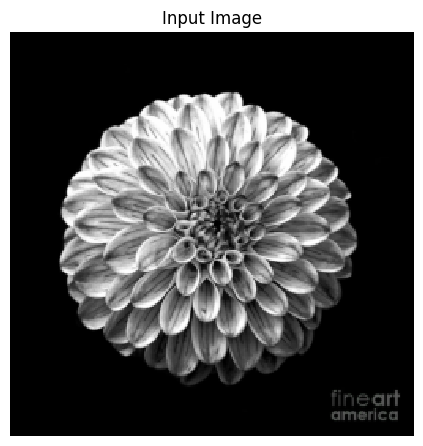

In [ ]:

# Initialize a list to store processed image data
test_image_data = []

# Path to the test image
test_image_path = r"Inputs\test1.jpg"

# Load and preprocess the test image
test_image = img_to_array(load_img(test_image_path))  # Load and convert the image to a NumPy array
test_image = resize(test_image, (256, 256), anti_aliasing=True)  # Resize the image to 256x256 pixels
test_image *= 1.0 / 255  # Normalize pixel values to the range [0, 1]

# Display the input image
plt.title("Input Image")
imshow(test_image)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


C:\Users\venka\AppData\Local\Temp\ipykernel_11988\2182251862.py:26: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 707 negative Z values that have been clipped to zero
  imshow(lab2rgb(reconstructed_image))


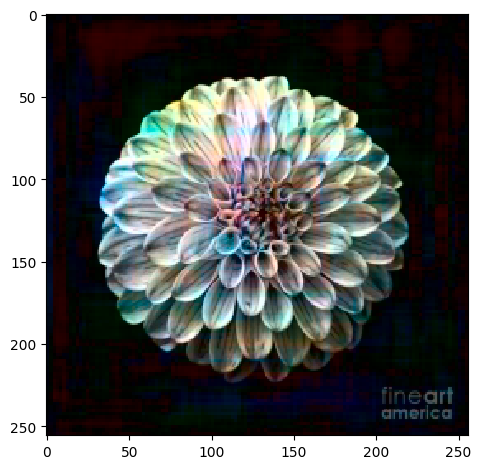

In [10]:
from skimage.color import rgb2lab, lab2rgb, gray2rgb
import numpy as np
from skimage.io import imshow

# Convert the test image from RGB to LAB color space
lab_image = rgb2lab(test_image)
l_channel = lab_image[:, :, 0]  # Extract the L channel

# Convert the L channel to RGB format for VGG16 model input
l_channel_rgb = gray2rgb(l_channel)  # Convert grayscale L channel to RGB
l_channel_rgb = l_channel_rgb.reshape((1, 256, 256, 3))  # Reshape to match model input dimensions

# Predict features using the VGG16 model
vgg16_output = vgg16_model.predict(l_channel_rgb)

# Predict AB channels using the trained autoencoder model
predicted_ab = autoencoder_model.predict(vgg16_output)
predicted_ab = predicted_ab * 128  # Denormalize AB channels

# Combine the L channel and predicted AB channels to form the LAB image
reconstructed_image = np.zeros((256, 256, 3))  # Initialize a blank LAB image
reconstructed_image[:, :, 0] = l_channel       # Add the original L channel
reconstructed_image[:, :, 1:] = predicted_ab  # Add the predicted AB channels

# Convert the reconstructed LAB image back to RGB and display it
imshow(lab2rgb(reconstructed_image))
